In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import glob, os
from math import ceil
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from six import print_
from six.moves import range, zip

In [2]:
FILE_EXT = 'tif'
TRAIN_DIR = 'data/train'

In [3]:
def get_image_sets(image_dir=TRAIN_DIR):
    prefix_len = len(os.path.join(image_dir, ''))
    imgs = glob.glob(os.path.join(image_dir, "*[0-9]_*[0-9].{}".format(FILE_EXT)))
    to_int = lambda k: tuple([int(i) for i in k.split('_')])
    return sorted([s[prefix_len:s.rindex('.')] for s in imgs], key=to_int)

def get_image(img_key, image_dir=TRAIN_DIR):
    return cv2.imread(os.path.join(image_dir, '{}.{}'.format(img_key, FILE_EXT)), cv2.IMREAD_GRAYSCALE)

def get_image_label(img_key, image_dir=TRAIN_DIR):
    return cv2.imread(os.path.join(image_dir, '{}_mask.{}'.format(img_key, FILE_EXT)), cv2.IMREAD_GRAYSCALE) // 255

In [4]:
img_keys = np.asarray(get_image_sets())

In [5]:
print("Training image count:", img_keys.shape[0])

Training image count: 5635


In [6]:
img_0 = get_image(img_keys[0])
print("Image shape:", img_0.shape)
print("Data type:", img_0.dtype)

Image shape: (420, 580)
Data type: uint8


In [7]:
def has_label(img_key, image_dir=TRAIN_DIR):
    img = get_image_label(img_key, image_dir=image_dir)
    return img.sum() > 0

has_label = np.vectorize(has_label, otypes=[np.bool], excluded=['image_dir'])
has_labels = has_label(img_keys)
print("Images with Brachial Plexus annotation:", has_labels.sum())

Images with Brachial Plexus annotation: 2323


In [8]:
def get_label_size(img_key, image_dir=TRAIN_DIR):
    return get_image_label(img_key, image_dir=image_dir).astype(np.uint64).sum()
get_label_size = np.vectorize(get_label_size, otypes=[np.uint64], excluded=['image_dir'])
label_size = get_label_size(img_keys[has_labels])

In [9]:
total_pixels = img_keys.shape[0] * img_0.shape[0] * img_0.shape[1]
pos_class_count = label_size.sum()
neg_class_count = total_pixels - int(label_size.sum())
print("Total pixel count:", total_pixels)
print("Positive class count:", pos_class_count)
print("Negative class count:", neg_class_count)

Total pixel count: 1372686000
Positive class count: 16553089
Negative class count: 1356132911


(-1.0057536597928423, 1.0022777204916926, -1.0041958390217431, 1.0)

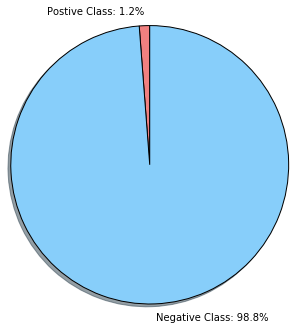

In [14]:
labels = ('Postive Class: {:0.1f}%'.format(100.0 * pos_class_count / total_pixels),
          'Negative Class: {:0.1f}%'.format(100.0 * neg_class_count / total_pixels))
sizes = [pos_class_count, neg_class_count]
colors = ['lightcoral', 'lightskyblue']
fig = plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, colors=colors, shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

In [11]:
print("Minimum label size:", label_size.min())
print("Maximum label size:", label_size.max())
print("Average label size:", label_size.mean())

Minimum label size: 2684
Maximum label size: 17439
Average label size: 7125.737839


(-1.0098283927122957, 1.0, -1.0113356274007421, 1.0215028668610564)

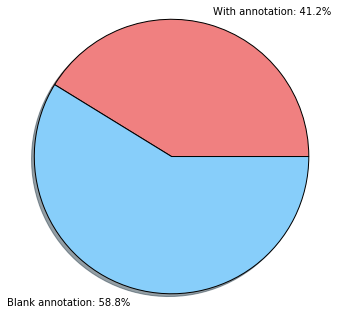

In [13]:
total_images = img_keys.shape[0]
images_with_labels = has_labels.sum()
images_no_labels = total_images - images_with_labels
labels = ('With annotation: {:0.1f}%'.format(100.0 * images_with_labels / total_images),
          'Blank annotation: {:0.1f}%'.format(100.0 * images_no_labels / total_images))
sizes = [images_with_labels, images_no_labels]
colors = ['lightcoral', 'lightskyblue']
fig = plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, colors=colors, shadow=True, startangle=0)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

In [182]:
def similarity(img_1, img_2):
    scanned = cv2.matchTemplate(img_1, img_2, cv2.TM_CCOEFF_NORMED)
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(scanned)
    return maxVal

def get_similar_images(group_id, src_img, count=None, threshold=0.8, with_mask_only=False):
    similars = []
    src = get_image(src_img)
    for i in range(1, 120 + 1):
        img_key = '{}_{}'.format(group_id, i)
        if similarity(src, get_image(img_key)) >= threshold:
            if with_mask_only:
                if has_label(img_key):
                    similars.append(img_key)
            else:
                similars.append(img_key)
            if count is not None and len(similars) >= count: break
    return similars

In [189]:
get_similar_images(23, '23_2', count=4, threshold=0.92, with_mask_only=True)

['23_2', '23_14', '23_67', '23_110']

In [177]:
def plot_img(img, ax, fname):
        if len(img.shape) > 2:
            ax.imshow(img)
        else:
            ax.imshow(img, cmap='gray')
        ax.set_title(fname)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [193]:
def show_imgs(*img_keys, **kwargs):
    show_mask = kwargs.get('show_mask', False)
    kernel = np.ones((3,3),np.uint8)
    
    img_count = len(img_keys)
    cols = 4
    rows = ceil(img_count / cols)
    
    fig = plt.figure(figsize=(13, 2.7 * rows))
    for i, k in enumerate(img_keys):
        img = get_image(k)
        if show_mask:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img_mask = get_image_label(k)
            
            # Highlight mask
            img[:,:,0] *= np.logical_not(img_mask)
            
            # Outline mask
            edges = cv2.Canny(img_mask * 255,  100,200)
            dilated = cv2.dilate(edges, kernel, iterations = 1) > 0
            img[dilated, 0]= 0
            img[dilated, 1]= 255
            img[dilated, 2]= 255
            
            
        plot_img(img,
                 fig.add_subplot(rows, cols, i + 1),
                 '{}.tif'.format(k))
    fig.tight_layout()
    plt.show()

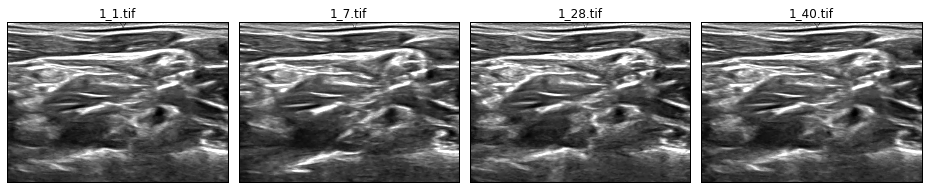

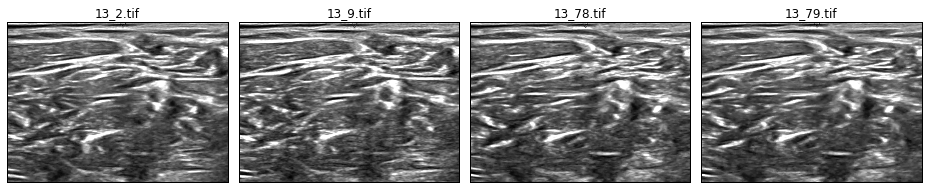

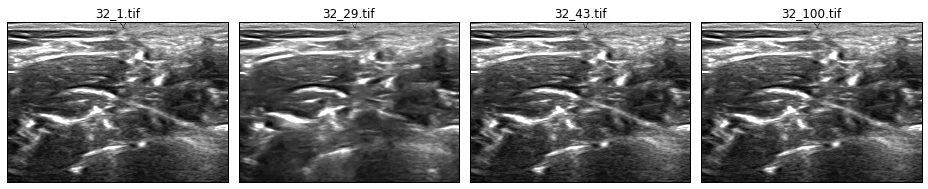

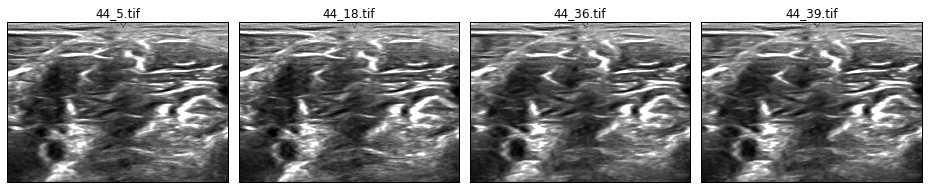

In [120]:
# Show similar images
show_imgs('1_1', '1_7', '1_28', '1_40')
show_imgs('13_2', '13_9', '13_78', '13_79')
show_imgs('32_1', '32_29', '32_43', '32_100')
show_imgs('44_5', '44_18', '44_36', '44_39')

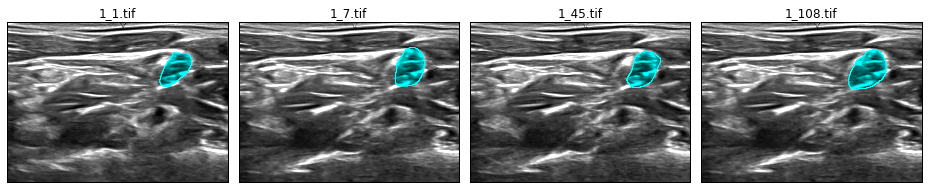

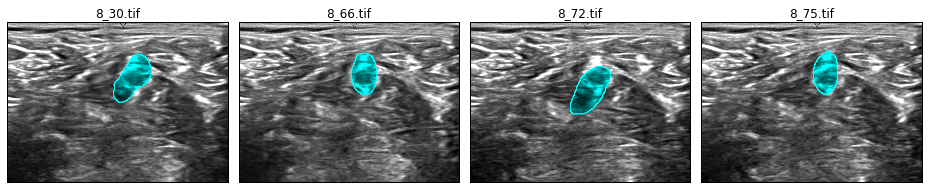

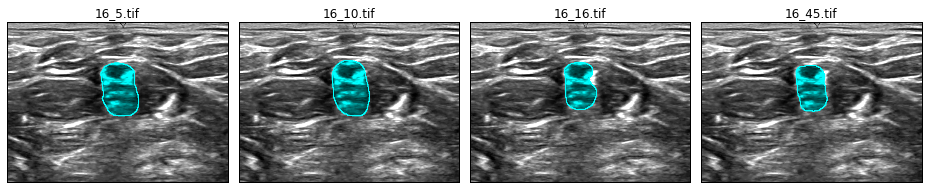

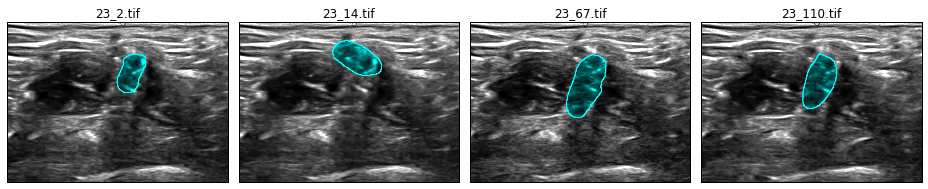

In [194]:
# Show similar images with anotations
show_imgs('1_1', '1_7', '1_45', '1_108', show_mask=True)
show_imgs('8_30', '8_66', '8_72', '8_75', show_mask=True)
show_imgs('16_5', '16_10', '16_16', '16_45', show_mask=True)
show_imgs('23_2', '23_14', '23_67', '23_110', show_mask=True)

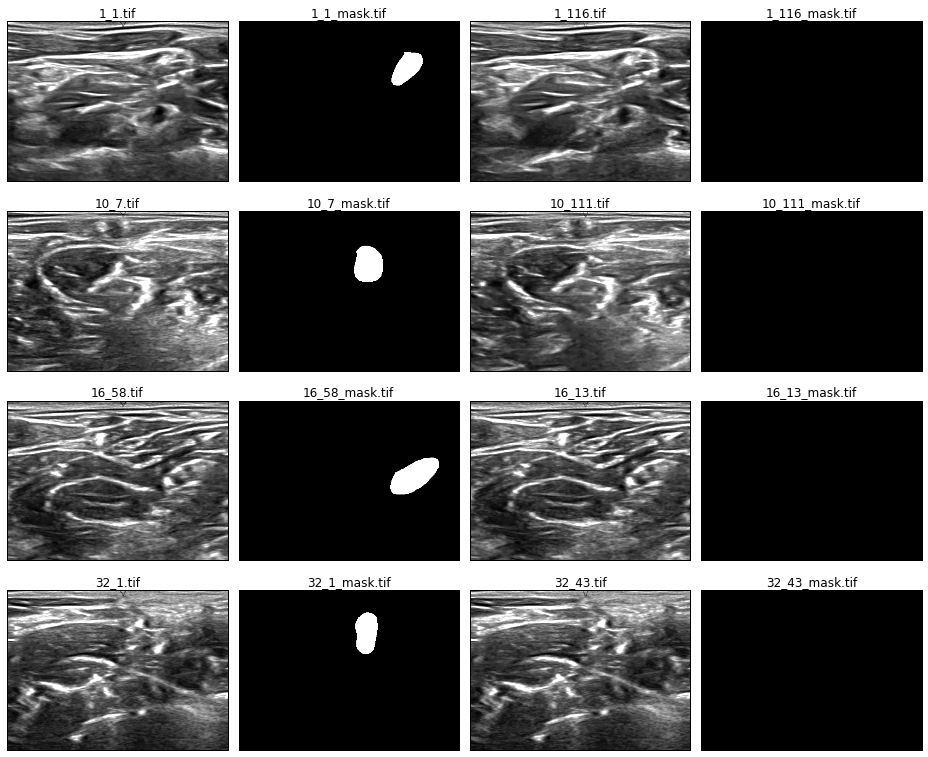

In [39]:
def show_masks(*img_keys):
    img_count = len(img_keys * 2)
    cols = 4
    rows = ceil(img_count / cols)

    fig = plt.figure(figsize=(13, 2.7 * rows))
    for i, k in enumerate(img_keys):
        plot_img(get_image(k),
                 fig.add_subplot(rows, cols, i * 2 + 1),
                 '{}.tif'.format(k))
        plot_img(get_image_label(k),
                 fig.add_subplot(rows, cols, i * 2 + 2),
                 '{}_mask.tif'.format(k))
    fig.tight_layout()
    
show_masks('1_1', '1_116', 
           '10_7', '10_111',
           '16_58', '16_13',
           '32_1', '32_43')